In [1]:
import os
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Pooling layer reduces size by half
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 256, 128)  # Adjusted for input size 2048
        self.fc2 = nn.Linear(128, 2)         # Output for binary classification

        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)    

    def forward(self, x):
        # Ensure input has the correct shape
        x = self._check_input_dimensions(x)

        # Convolutional layers with ReLU activation and max-pooling
        x = self.pool(self.relu(self.conv1(x)))  # Output: (batch_size, 16, 1024)
        x = self.pool(self.relu(self.conv2(x)))  # Output: (batch_size, 32, 512)
        x = self.pool(self.relu(self.conv3(x)))  # Output: (batch_size, 64, 256)

        # Flatten and pass through fully connected layers
        x = self.flatten(x)              
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def _check_input_dimensions(self, x):
        if len(x.shape) == 2:  
            x = x.unsqueeze(1) 
        return x

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    batch_losses = []
    
    pbar = tqdm(dataloader, desc="Training", total=len(dataloader), unit="batchs", leave=False)
    
    for batch, (sample, label) in enumerate(pbar):
        sample, label = sample.to(device), label.to(device)

        pred = model(sample)
        loss = loss_fn(pred, label)
        
        batch_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())
    
    loss = loss.cpu().detach().numpy()

    return loss, batch_losses


def test(dataloader, model):
    model.eval()
    total, correct = 0, 0
    batch_accuracies = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Testing", total=len(dataloader), unit="batchs", leave=False)
        for sample, label in pbar:
            sample, label = sample.to(device), label.to(device)
            output = model(sample)
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

            batch_accuracy = 100 * (predicted == label).sum().item() / label.size(0)
            batch_accuracies.append(batch_accuracy)

            pbar.set_postfix(accuracy=100 * correct / total)

    overall_accuracy = 100 * correct / total
    return overall_accuracy, batch_accuracies

class psd_dataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.file_list = []
        for root, _, files in os.walk(data_path):
            for file in files:
                if file.endswith('.npy'):
                    self.file_list.append(os.path.join(root, file))
        self.label_map = {'wifi': 0, 'bluetooth': 1}
        print(f"Found {len(self.file_list)} files in {data_path}")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        data = torch.from_numpy(np.load(file_path))

        label_str = os.path.basename(os.path.dirname(file_path))
        label_str = label_str.split('_')[0]
        label = self.label_map.get(label_str, -1)
        if label == -1:
            raise ValueError(f"Invalid label: {label_str}")

        return data, label
print(f"Using {device} device")

Using cuda device


In [3]:
bSize = 4096
epochs = 25

training_dataset = psd_dataset("../../data/open_data/training_psd/")
testing_dataset = psd_dataset("../../data/open_data/testing_psd/")

training_dataloader = DataLoader(training_dataset, batch_size=bSize, shuffle=True, num_workers=8)
testing_dataloader = DataLoader(testing_dataset, batch_size=bSize, shuffle=True, num_workers=8)

Found 175776 files in ../../data/open_data/training_psd/
Found 58592 files in ../../data/open_data/testing_psd/


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Training:   0%|          | 0/43 [00:00<?, ?batchs/s]

Testing:   0%|          | 0/15 [00:00<?, ?batchs/s]

Done!
Saved PyTorch Model State to model.pth


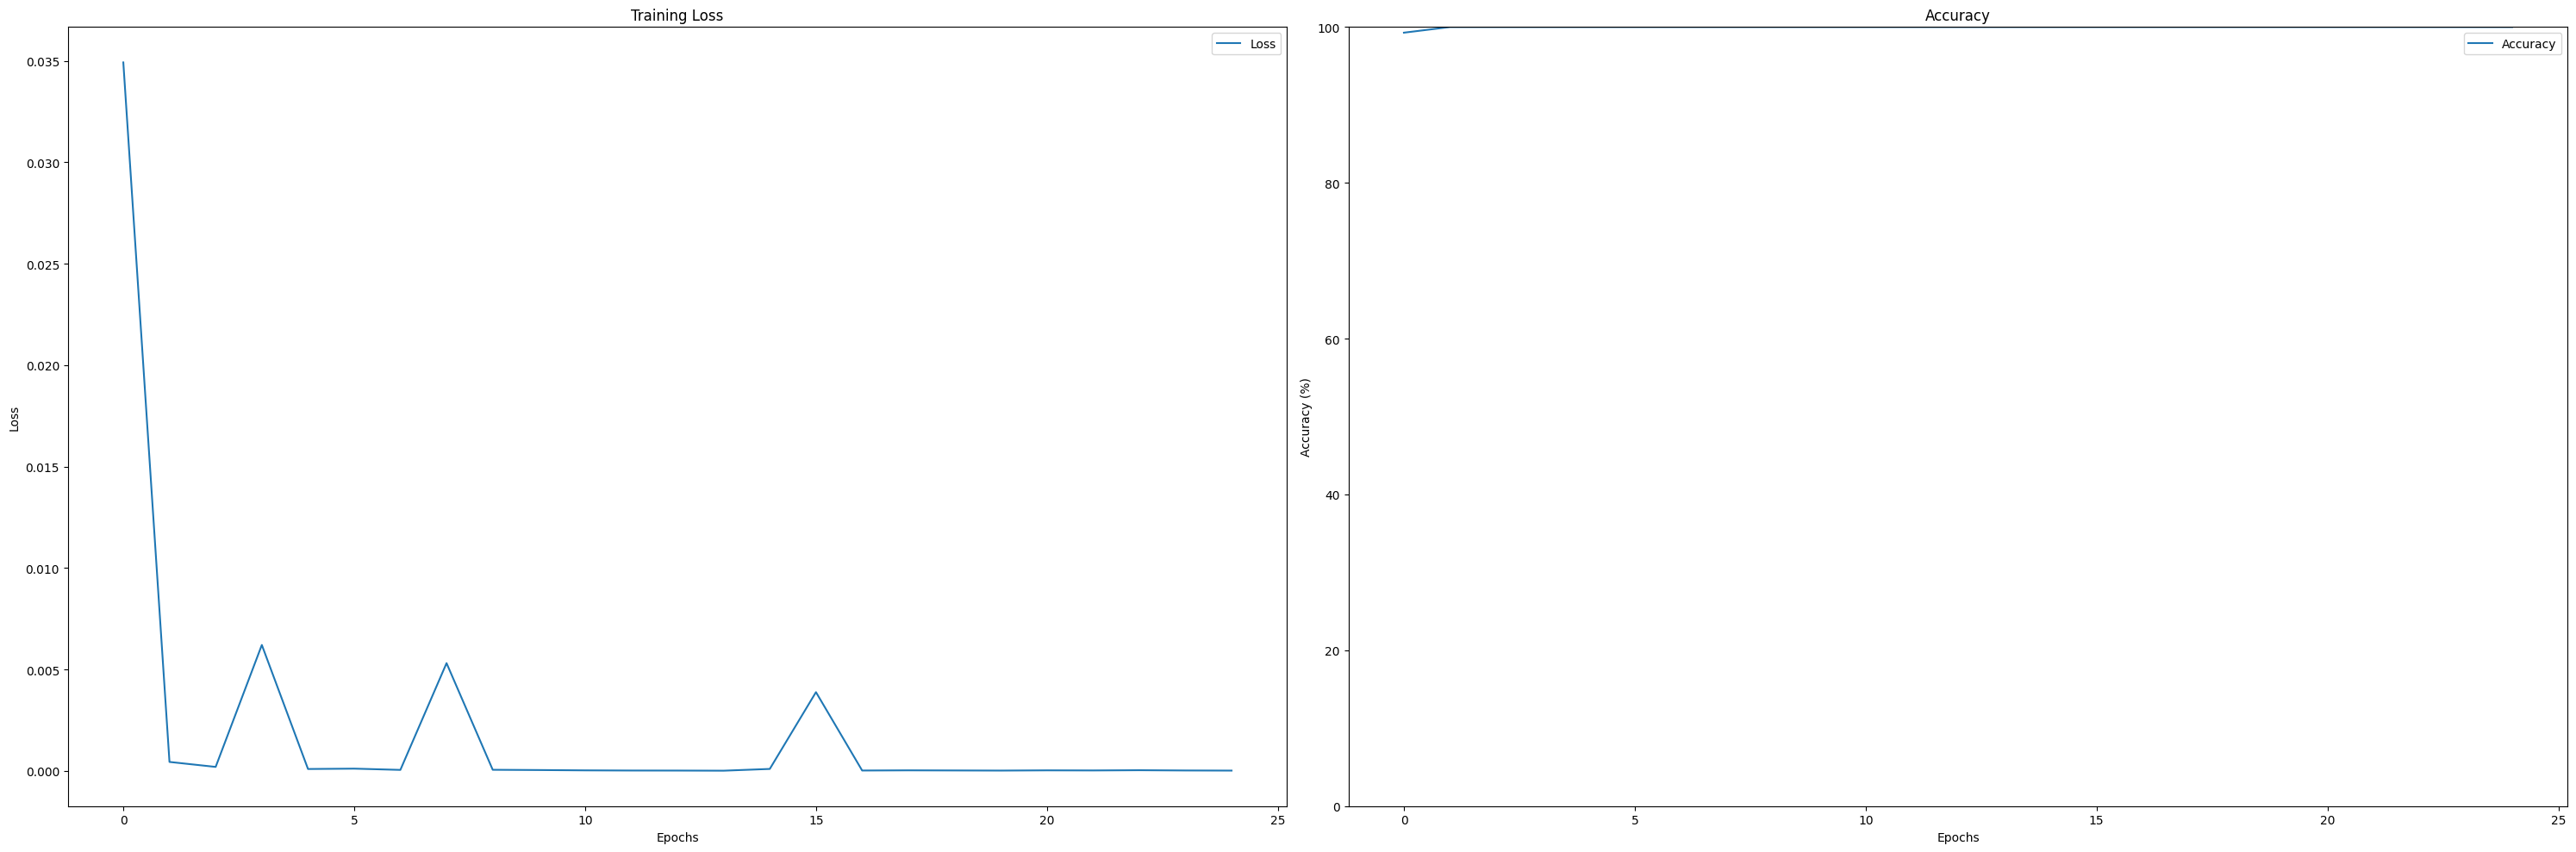

In [4]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
test_losses = []
accuracies = []

for t in tqdm(range(epochs), desc="Epochs", total=epochs):
    train_loss, train_batch_loss = train(training_dataloader, model, loss_fn, optimizer)
    accuracy, batch_accuracy = test(testing_dataloader, model)
    train_losses.append(train_loss)
    accuracies.append(accuracy)

print("Done!")
torch.save(model, f"model_01_11_15_batch_size_{bSize}.pth")
# torch.save(model.state_dict(), "model.pth")

print("Saved PyTorch Model State to model.pth")
plt.figure(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.legend()

plt.tight_layout()
plt.show()